# RELIANCE CLOSING PRICE ANALYSIS

### Script By
Rachit Agarwal https://www.linkedin.com/in/racag

In [1]:
# Library used for loading the data and Preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Library used for checking Trend, Seasonality, Cyclic and Random Variation 
import statsmodels.api as ap    

# Libraries for Building the Models
from statsmodels.tsa.api import SimpleExpSmoothing as ses   # Simple / Single Exponential Smoothing 
from statsmodels.tsa.api import Holt                        # Holt's Linear Trend / Double Exponential Smoothing 
from statsmodels.tsa.api import ExponentialSmoothing as es  # Holt's Winter / Tripple Exponential Smoothing
import pmdarima as pm                                       # ARIMA

# Library used for checking Stationarity 
from statsmodels.tsa.stattools import adfuller

# Libraries for Evaluation Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Loading the data

data = pd.read_csv('RELIANCE_NS.csv')
data.shape

(6282, 7)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,16.009800,16.095699,15.904300,16.0683,2.422041,47600787.0
1,1996-01-02,16.029301,16.107401,15.826200,15.9434,2.403215,77143764.0
2,1996-01-03,16.205000,16.943001,16.029301,16.0644,2.421453,95695836.0
3,1996-01-04,15.912100,15.962900,15.701300,15.9160,2.399085,99159504.0
4,1996-01-05,15.853600,15.853600,15.670000,15.8067,2.382609,76213503.0


In [4]:
# Keeping the Date and Closing Price Variable

data1 = data[['Date','Close']]
data1.head()

,Date,Close
0,1996-01-01,16.0683
1,1996-01-02,15.9434
2,1996-01-03,16.0644
3,1996-01-04,15.9160
4,1996-01-05,15.8067


In [5]:
# Checking the Range of Date variable

data1['Date'].min(), data1['Date'].max() 

('1996-01-01', '2020-11-27')

In [6]:
# Checking for Null Values

data1.isnull().sum()

Date       0
Close    127
dtype: int64

In [7]:
data1[data1['Close'].isnull()]

,Date,Close
19,1996-01-26,NaN
37,1996-02-21,NaN
46,1996-03-05,NaN
57,1996-03-20,NaN
69,1996-04-05,NaN
...,...,...
4297,2012-11-11,NaN
4634,2014-03-22,NaN
4863,2015-02-28,NaN
6008,2019-10-27,NaN


In [8]:
# Grouping the data by Date
# so that if two values are present for same date then the closing price is added

data2 = data1.groupby('Date')['Close'].sum()
data2.shape

(6282,)

### Now you can see that the shape remains as it after grouping the data
### So there is no difference if you do not perform the above step

### CHECKING DATATYPES

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6282 non-null   object 
 1   Close   6155 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.3+ KB


In [10]:
# Converting the Date variable to 'date' datatype

data1['Date'] = data1['Date'].astype('datetime64')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6282 non-null   datetime64[ns]
 1   Close   6155 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 98.3 KB


In [11]:
# Setting the Date variable as Index

data1.set_index('Date', inplace = True)
data1.head()

,Close
Date,
1996-01-01,16.0683
1996-01-02,15.9434
1996-01-03,16.0644
1996-01-04,15.9160
1996-01-05,15.8067


In [12]:
# Resampling the data to Monthly data by taking Average

y = data1['Close'].resample('M').mean()
y.shape

(299,)

In [13]:
# Checking for Null's

y.isnull().sum()

0

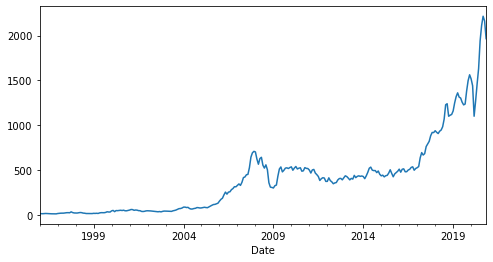

In [14]:
# Plotting the resampled data

y.plot(figsize = (8,4))
plt.show()

### TRAIN TEST SPLIT

In [15]:
# Training part consist of data from Jan 1996 to Dec 2014

train = y.loc[:'2014-12-31']
train.tail()

Date
2014-08-31    496.230262
2014-09-30    497.222727
2014-10-31    474.208335
2014-11-30    491.937500
2014-12-31    455.624997
Freq: M, Name: Close, dtype: float64

In [16]:
# Testing part consist of data from Jan 2015 to Nov 2020

test = y.loc['2015-01-31':]
test.tail()

Date
2020-07-31    1939.930436
2020-08-31    2110.792899
2020-09-30    2214.381836
2020-10-31    2161.842855
2020-11-30    1964.847367
Freq: M, Name: Close, dtype: float64

In [17]:
# Shape of Training and Testing data

train.shape, test.shape

((228,), (71,))

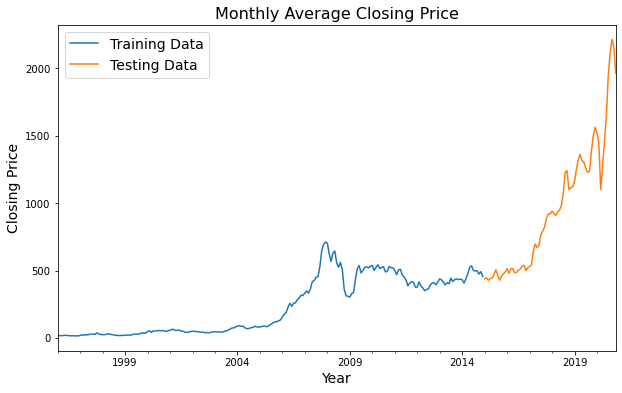

In [18]:
# Plotting the Training and Testing data

plt.figure(figsize = (10,6))
train.plot()
test.plot()

plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data','Testing Data'], loc = 0, fontsize = 14)
plt.show()

### Decomposing the data into Trend & Seasonality

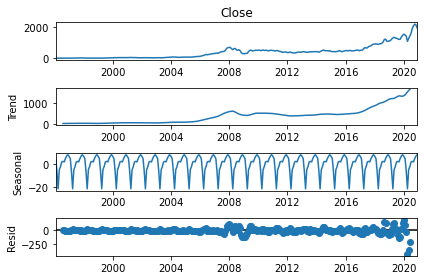

In [19]:
# 1st graph -> observed values
# 2nd graph -> trend component
# 3rd graph -> seasonality component
# 4th graph -> Residual

# if only trend then use double exponential / HOLT LINEAR TREND 
# trend and seasonality then use triple exponential / HOLT WINTER METHOD


dc = ap.tsa.seasonal_decompose(y)
dc.plot()
plt.show()

## MODEL BUILDING & EVALUATION

In [20]:
# Creating a dataframe to store the RMSE and AIC values of each Model

result = pd.DataFrame(columns = ['Algorithm','RMSE','AIC'])

result['Algorithm'] = ['Single Exponential', 'Double Exponential', 'Triple Exponential','ARIMA']

result.set_index('Algorithm', inplace = True)

# result.head()

In [21]:
# Creating a dataframe to store the Predicted values of each Model

prediction = pd.DataFrame(columns = ['Actual Values'])
prediction['Actual Values'] = test.copy()

# prediction.head()

In [22]:
# User Defined Function to Calclulate the RMSE & AIC

def metric(model, actual_value, predicted_value):
    rmse = round(sqrt(mean_squared_error(actual_value, predicted_value)),4)
    aic = round(model.aic,4)
    return rmse,aic

### SIMPLE / SINGLE EXPONENTIAL SMOOTHING

In [23]:
# smoothing_level = alpha
# range is 0 to 1
# close to 0 -> older values are less important compared to recent values
# close to 1 -> older values are equally important


model_Single = ses(train).fit(smoothing_level = 0.26)
prediction['Single'] = model_Single.forecast(len(test))

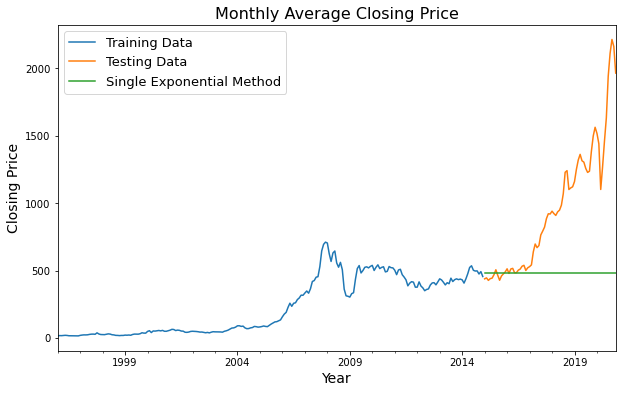

In [24]:
plt.figure(figsize = (10,6))

train.plot()
test.plot()
prediction['Single'].plot()

plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data','Testing Data','Single Exponential Method'], fontsize = 13)
plt.show()

In [25]:
rmse,aic = metric(model_Single,prediction['Actual Values'],prediction['Single'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Single Exponential','RMSE'] = rmse
result.loc['Single Exponential','AIC'] = aic

RMSE : 669.426 
AIC : 1735.49


### HOLT's LINEAR TREND / DOUBLE EXPONENTIAL SMOOTHING

In [26]:
# smoothing_level = alpha
# range is 0 to 1
# close to 0 -> older values are less important compared to recent values
# close to 1 -> older values are equally important


# smoothing_slope -> beta
# Angle at which trend occurs
# range 0 to 1


model_Double = Holt(train).fit(smoothing_level = 0.26, smoothing_slope = 0.099)
prediction['Double'] = model_Double.forecast(len(test))

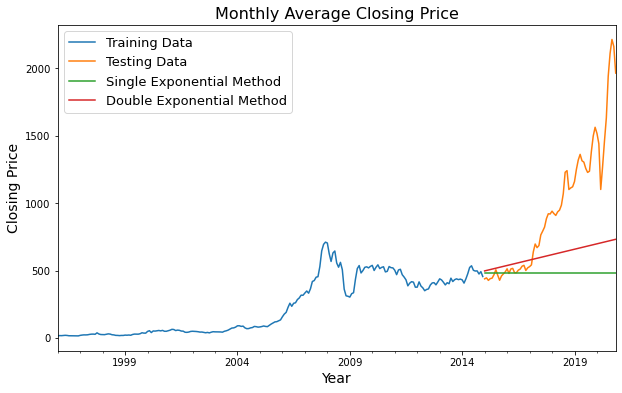

In [27]:
plt.figure(figsize = (10,6))

train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()

plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data','Testing Data','Single Exponential Method',
            'Double Exponential Method'], fontsize = 13)
plt.show()

In [28]:
rmse,aic = metric(model_Double,prediction['Actual Values'],prediction['Double'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Double Exponential','RMSE'] = rmse
result.loc['Double Exponential','AIC'] = aic

RMSE : 531.5136 
AIC : 1756.5778


### HOLT's WINTER / TRIPLE EXPONENTIAL SMOOTHING

In [29]:
# seasonal_periods = 12 -> 12 months the pattern is repeating
# trend = 'add' -> type of model to be build -> additive model
# trend = 'mul' -> type of model to be build -> multiplicative model


model_Triple = es(train, trend = 'mul', seasonal = 'mul', seasonal_periods = 12).fit()
prediction['Triple'] = model_Triple.forecast(len(test))

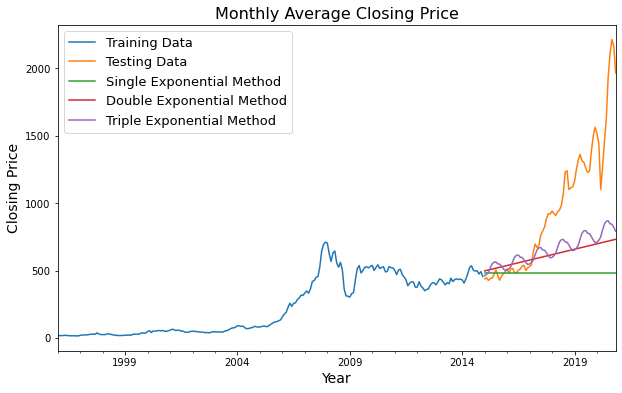

In [30]:
plt.figure(figsize = (10,6))

train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()
prediction['Triple'].plot()

plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data','Testing Data','Single Exponential Method',
            'Double Exponential Method','Triple Exponential Method'], fontsize = 13)
plt.show()

In [31]:
rmse,aic = metric(model_Triple,prediction['Actual Values'],prediction['Triple'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Triple Exponential','RMSE'] = rmse
result.loc['Triple Exponential','AIC'] = aic

RMSE : 486.1228 
AIC : 1578.0206


### Checking for Stationarity of data

#### H0 : Data is non-stationary              <- Null Hypothesis
#### H1 : Data is stationary                      <- Alternate Hypothesis

In [32]:
ad = adfuller(y)
print('P-value :',ad[1])

P-value : 1.0


#### Since P-value is greater than 5% we reject the Null Hypothesis
#### So the data is stationary

### ARIMA MODEL

In [33]:
# y -> data

# start_p -> starting p value
# max_p -> maximum p value

# d = None -> no differencing
# max_d = 2 -> if required then upto 2nd order differencing

# start_q -> starting q value
# max_q -> maximum q value

# similar for P,D,Q

# max_order = 10 -> to set restriction
# sumation of p,q and P,Q should be less then equal to 10
# p+q + P+Q <= 10 
# p+q <= 3

# seasonality m = 12 -> yearly pattern
# seasonal = True -> use SARIMA

# information_criterion = 'aic' -> model evaluation parameter

# test = adf -> if data is non stationary

# trace = True -> for displaying all combinations 

In [34]:
model_arima = pm.auto_arima(y, start_p = 0, max_p = 3, 
                      d = None, max_d = 2,
                      start_q = 0, max_q = 3,
                      start_P = 0, max_P = 3, 
                      D = None, max_D = 1, 
                      start_Q = 0, max_Q = 3,
                      max_order = 15,
                      m = 12, seasonal = True,
                      information_criterion = 'aic',
                      stepwise = False,
                      suppress_warnings = True,
                      test = 'adf',
                      trace = True,
                      random_state = 10)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3153.045, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3138.795, Time=0.41 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3129.131, Time=1.08 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=3127.597, Time=2.83 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3130.059, Time=0.41 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3126.786, Time=0.68 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3126.623, Time=2.12 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=3128.605, Time=7.75 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3125.010, Time=1.46 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3126.991, Time=2.45 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3128.605, Time=3.08 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=3130.603, Time=6.84 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=3126.982, Time=4.45 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=3128.857, Time=9.18 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=3130.577, Time=10.2

 ARIMA(1,1,3)(2,0,2)[12] intercept   : AIC=3098.836, Time=7.99 sec
 ARIMA(1,1,3)(2,0,3)[12] intercept   : AIC=3100.578, Time=21.38 sec
 ARIMA(1,1,3)(3,0,0)[12] intercept   : AIC=3094.658, Time=14.24 sec
 ARIMA(1,1,3)(3,0,1)[12] intercept   : AIC=3099.468, Time=14.32 sec
 ARIMA(1,1,3)(3,0,2)[12] intercept   : AIC=3100.564, Time=18.42 sec
 ARIMA(1,1,3)(3,0,3)[12] intercept   : AIC=3102.546, Time=22.96 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3101.300, Time=0.26 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3094.611, Time=0.55 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=3094.180, Time=1.40 sec
 ARIMA(2,1,0)(0,0,3)[12] intercept   : AIC=3094.191, Time=3.58 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3092.377, Time=0.89 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3092.657, Time=1.14 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=3094.505, Time=3.63 sec
 ARIMA(2,1,0)(1,0,3)[12] intercept   : AIC=3096.048, Time=10.77 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=3092.695, Tim

 ARIMA(3,1,3)(1,0,0)[12] intercept   : AIC=3056.163, Time=3.06 sec
 ARIMA(3,1,3)(1,0,1)[12] intercept   : AIC=3056.868, Time=5.16 sec
 ARIMA(3,1,3)(1,0,2)[12] intercept   : AIC=3061.564, Time=12.78 sec
 ARIMA(3,1,3)(1,0,3)[12] intercept   : AIC=3061.085, Time=26.15 sec
 ARIMA(3,1,3)(2,0,0)[12] intercept   : AIC=3058.393, Time=8.24 sec
 ARIMA(3,1,3)(2,0,1)[12] intercept   : AIC=3054.166, Time=11.51 sec
 ARIMA(3,1,3)(2,0,2)[12] intercept   : AIC=3055.498, Time=12.63 sec
 ARIMA(3,1,3)(2,0,3)[12] intercept   : AIC=3057.537, Time=26.90 sec
 ARIMA(3,1,3)(3,0,0)[12] intercept   : AIC=3053.271, Time=20.70 sec
 ARIMA(3,1,3)(3,0,1)[12] intercept   : AIC=3057.717, Time=26.46 sec
 ARIMA(3,1,3)(3,0,2)[12] intercept   : AIC=3057.823, Time=26.01 sec
 ARIMA(3,1,3)(3,0,3)[12] intercept   : AIC=3060.536, Time=29.90 sec
Total fit time: 2208.068 seconds


In [35]:
# Summary of the ARIMA Model

model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -1515.726
Date:                Tue, 01 Dec 2020   AIC                           3047.453
Time:                        14:43:35   BIC                           3077.030
Sample:                             0   HQIC                          3059.292
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.1873      2.918      2.120      0.034       0.468      11.906
ar.L1          0.9238      0.120      7.694      0.000       0.688       1.159
ar.L2         -0.3312      0.179     -1.846      0.065      -0.683       0.020
ar.L3         -0.4674      0.130     -3.598      0.000      -0.722      -0.213
ma.L1         -0.5805      0.104     -5.607      0.000      -0.783      -0.378
ma.L2          0.0996      0.141      0.708      0.479      -0.176       0.375
ma.L3          0.6123      0.094      6.547      0.000       0.429       0.796
sigma2      1525.3502     65.090     23.434      0.000    1397.776    1652.925
===================================================================================
Ljung-Box (Q):                       28.33   Jarque-Bera (JB):              5665.21
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              75.52   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Best Values Choosen 

model_arima

ARIMA(order=(3, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [37]:
# Building the SARIMAX Model

from statsmodels.tsa.statespace.sarimax import SARIMAX as sa

model_sarimax = sa(y, order = (3,1,3), seasonal_order = (0,0,0,12)).fit(maxiter = 200)

In [38]:
pred = model_sarimax.get_prediction(start = pd.to_datetime('2015-01-31'))
prediction['ARIMA'] = pred.predicted_mean

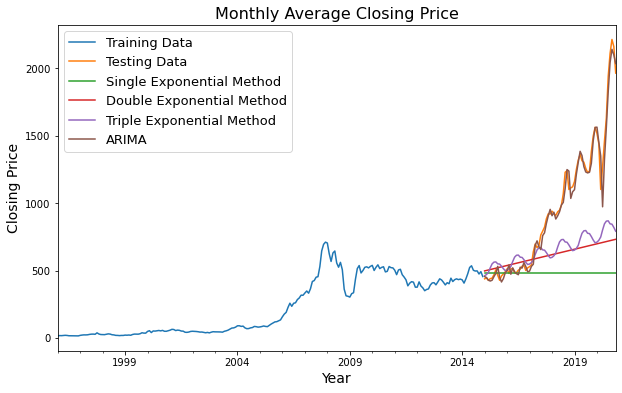

In [39]:
plt.figure(figsize = (10,6))

train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()
prediction['Triple'].plot()
pred.predicted_mean.plot()

plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data','Testing Data','Single Exponential Method',
            'Double Exponential Method','Triple Exponential Method','ARIMA'], fontsize = 13)
plt.show()

In [40]:
rmse,aic = metric(model_sarimax,prediction['Actual Values'],prediction['ARIMA'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['ARIMA','RMSE'] = rmse
result.loc['ARIMA','AIC'] = aic

RMSE : 67.4317 
AIC : 3056.1871


## FORECASTING

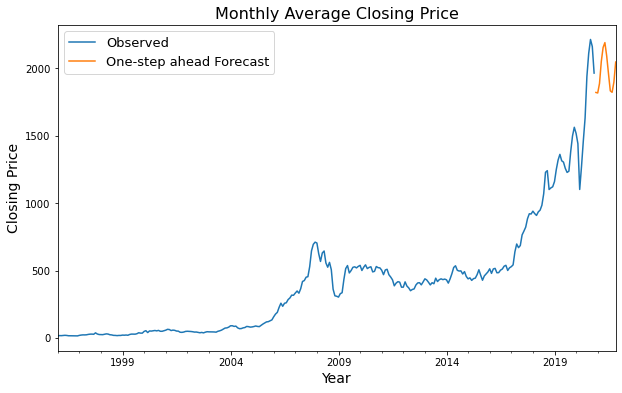

In [41]:
pred_uc = model_sarimax.get_forecast(steps = 12)
plt.figure(figsize = (10,6))
ax = y['1996':].plot()
pred_uc.predicted_mean.plot(ax = ax)

plt.title('Monthly Average Closing Price', fontsize = 16)
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Closing Price', fontsize = 14)

plt.legend(['Observed','One-step ahead Forecast'], fontsize = 13)
plt.show()

In [42]:
pred_uc.predicted_mean

2020-12-31    1821.176359
2021-01-31    1817.313540
2021-02-28    1887.670616
2021-03-31    2051.073477
2021-04-30    2155.059397
2021-05-31    2190.969845
2021-06-30    2091.427482
2021-07-31    1959.600740
2021-08-31    1832.998266
2021-09-30    1822.171078
2021-10-31    1898.363088
2021-11-30    2046.989881
Freq: M, dtype: float64

## Model wise Evaluation 

In [43]:
result.head()

,RMSE,AIC
Algorithm,,
Single Exponential,669.426,1735.49
Double Exponential,531.514,1756.58
Triple Exponential,486.123,1578.02
ARIMA,67.4317,3056.19


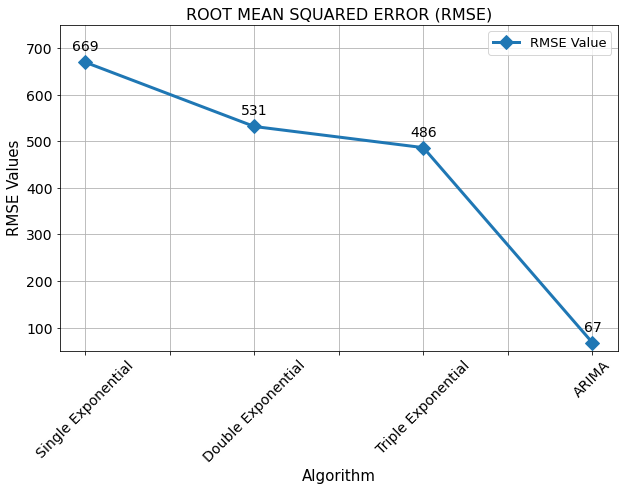

In [44]:
plt.figure(figsize = (10,6))
result['RMSE'].plot(marker = 'D', markersize = 10, linewidth = 3)
plt.title('ROOT MEAN SQUARED ERROR (RMSE)', fontsize = 16)
plt.xlabel('Algorithm', fontsize = 15)
plt.ylabel('RMSE Values', fontsize = 15)

plt.legend(['RMSE Value'], fontsize = 13)
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(50,750)


for i, v in enumerate(result['RMSE']):
    plt.text(i, v+25, "%d" %v, ha = 'center', fontsize = 14)

plt.grid()
plt.show()

## Model wise Prediction

In [45]:
prediction.head()

,Actual Values,Single,Double,Triple,ARIMA
Date,,,,,
2015-01-31,438.215476,479.602217,497.127518,461.104348,454.898764
2015-02-28,445.455264,479.602217,500.477921,470.257553,447.989384
2015-03-31,426.830953,479.602217,503.828325,485.964782,428.409215
2015-04-30,439.760525,479.602217,507.178728,519.975196,422.048302
2015-05-31,443.486249,479.602217,510.529131,549.374059,428.041738
